In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import missingno as mo
from scipy.interpolate import interp1d
from scipy.stats import shapiro
from OUTLIERS import smirnov_grubbs as grubbs

TODO:
- [ ] Add more visualizations (Sophie)
- [ ] Missing values          (Amir)
  - [x] backfill for 1 day
  - [x] In case of long missing values, we still have to figure out what to do 
    - Most missing values after the day baqckfilling ended up being the most obscure appCat's so I simply set them to 0
  - [-] Aggregating over Days/Hours

- [ ] Outlier detection        (Sophie)
  - [ ] Grubs/ VIF/ Cook's distance (Not all of them)

- [ ] Feature engineering     (Nabila)
  - [ ] PCA                   
    - [ ] Whitening
    


In [2]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 6),
    "figure.dpi": 100,
    "savefig.dpi": 200,
    "savefig.format": "png",
    "savefig.transparent": True,
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "grid.color": "0.8",
    "image.cmap": "Blues",
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "text.usetex": True, "mathtext.fontset": "cm",
    "pgf.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{cmbright}"
})


In [3]:
data = pd.read_csv("../data/raw/dataset_mood_smartphone.csv", index_col=0)
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.round('H')
print(data.tail())

              id                time        variable   value
2770399  AS14.30 2014-04-11 08:00:00  appCat.weather   8.032
2772465  AS14.30 2014-04-19 11:00:00  appCat.weather   3.008
2774026  AS14.30 2014-04-26 10:00:00  appCat.weather   7.026
2774133  AS14.30 2014-04-27 01:00:00  appCat.weather  23.033
2784435  AS14.32 2014-04-07 18:00:00  appCat.weather  22.431


/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_24793/677779932.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['time'] = data['time'].dt.round('H')


In [4]:
# Convert time column to datetime format
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.round('H')


# Pivot the data to create separate columns for each variable
data_pivot = data.pivot_table(index=['id', 'time'], columns='variable', values='value')

# Reset the index to flatten the column hierarchy
data_pivot.reset_index(inplace=True)

/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_24793/3801684769.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['time'] = data['time'].dt.round('H')


In [5]:
print(data_pivot.describe().to_markdown())

|       | time                          |      activity |   appCat.builtin |   appCat.communication |   appCat.entertainment |   appCat.finance |   appCat.game |   appCat.office |   appCat.other |   appCat.social |   appCat.travel |   appCat.unknown |   appCat.utilities |   appCat.weather |   call |   circumplex.arousal |   circumplex.valence |       mood |        screen |   sms |
|:------|:------------------------------|--------------:|-----------------:|-----------------------:|-----------------------:|-----------------:|--------------:|----------------:|---------------:|----------------:|----------------:|-----------------:|-------------------:|-----------------:|-------:|---------------------:|---------------------:|-----------:|--------------:|------:|
| count | 27028                         | 22965         |       12309      |             12797      |              5180      |        329       |      398      |       979       |      5442      |       6052      |        921      |

|       | time                          |     activity |   appCat.builtin |   appCat.communication |   appCat.entertainment |   appCat.finance |   appCat.game |   appCat.office |   appCat.other |   appCat.social |   appCat.travel |   appCat.unknown |   appCat.utilities |   appCat.weather |   call |   circumplex.arousal |   circumplex.valence |        mood |        screen |   sms |
|:------|:------------------------------|-------------:|-----------------:|-----------------------:|-----------------------:|-----------------:|--------------:|----------------:|---------------:|----------------:|----------------:|-----------------:|-------------------:|-----------------:|-------:|---------------------:|---------------------:|------------:|--------------:|------:|
| count | 27028                         | 27026        |      27027       |             27027      |              27026     |       26287      |    23775      |      26974      |     27025      |      27026      |      27022      |       27019      |         27027      |       25009      |  27022 |         27028        |         27028        | 27028       | 27026         | 27005 |
| mean  | 2014-04-14 16:34:06.144738816 |     0.120058 |         42.3545  |                45.6104 |                120.543 |          31.3167 |      356.289  |         45.7802 |        20.9953 |         89.0727 |         50.4012 |          42.3354 |            18.4875 |          29.719  |      1 |            -0.217589 |             0.668732 |     6.94341 |   113.027     |     1 |
| min   | 2014-02-17 07:00:00           |     0        |      -6343.29    |                 0.117  |                  0.005 |           1.003  |        1.003  |          0.044  |         0.014  |          0.552  |          0.08   |           0.111  |             0.976  |           1.007  |      1 |            -2        |            -2        |     1       |     0.0350001 |     1 |
| 25%   | 2014-04-02 06:45:00           |     0        |          4.41667 |                13.12   |                 10.794 |           8.014  |       80.6005 |         10.046  |         8.037  |         17.861  |         22.122  |          11.044  |             4.033  |           5.22   |      1 |            -1        |             0        |     6       |    19.334     |     1 |
| 50%   | 2014-04-15 15:00:00           |     0.025    |          8.02163 |                27.6707 |                 34.246 |          21.601  |      169.699  |         23.264  |        10.257  |         44.566  |         38.4282 |          21.185  |            10.537  |          10.147  |      1 |             0        |             1        |     7       |    44.771     |     1 |
| 75%   | 2014-04-27 22:00:00           |     0.158333 |         16.3092  |                51.6465 |                123.965 |          51.205  |      478.826  |         45.241  |        16.514  |        102.588  |         61.5086 |          30.178  |            20.0615 |          22.431  |      1 |             1        |             1        |     8       |    94.8592    |     1 |
| max   | 2014-06-09 00:00:00           |     1        |      19453       |              3133.48   |               2929.61  |         315.481  |     4115.3    |       4675.7    |      2243.24   |      15001.5    |       3492.32   |        2239.94   |           447.918  |         344.863  |      1 |             2        |             2        |    10       |  9539.82      |     1 |
| std   | nan                           |     0.190739 |        582.008   |                85.285  |                217.58  |          29.7814 |      634.744  |         80.0885 |        56.8702 |        161.532  |         76.5206 |         108.084  |            38.2665 |          70.1424 |      0 |             1.0681   |             0.686026 |     1.0813  |   338.403     |     0 |

In [6]:
# fill in the screen time for the entire day, sum the number of sms and call for the entire day
data_pivot['day'] = data_pivot['time'].dt.floor('D')
data_pivot['screen'] = data_pivot['screen'].groupby([data_pivot['id'], data_pivot['day']]).transform('sum')
data_pivot['sms'] = data_pivot['sms'].groupby([data_pivot['id'], data_pivot['day']]).transform('sum')
data_pivot['call'] = data_pivot['call'].groupby([data_pivot['id'], data_pivot['day']]).transform('sum')

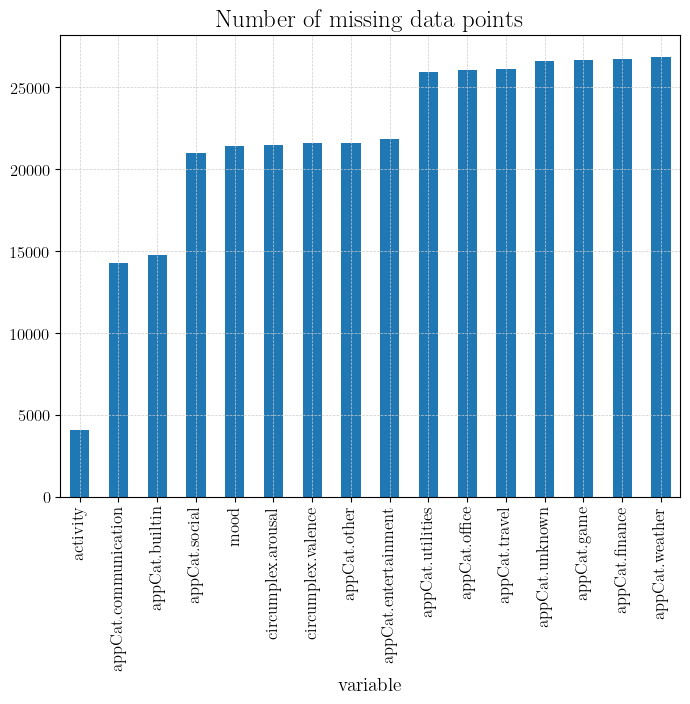

In [7]:
# Visualize the number of missing data points
missing = data_pivot.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot(kind='bar', title='Number of missing data points')
plt.show()

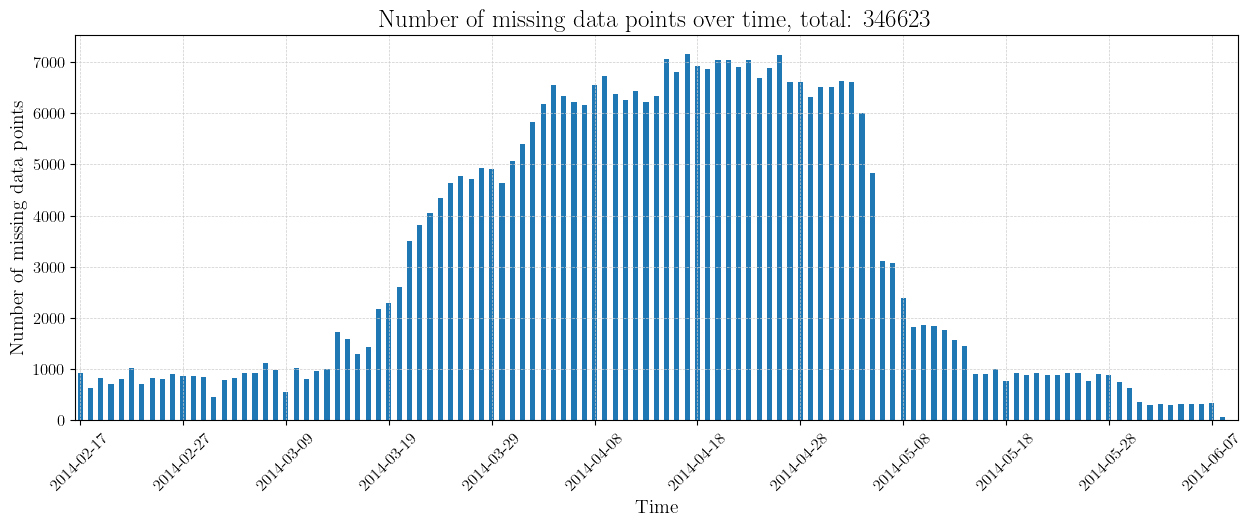

In [8]:

# Visualzing the missing data using a stacked bar plot over time
missing = data_pivot.isna().sum(axis=1)
missing = missing.groupby(data_pivot['time'].dt.floor('D')).sum()
missing.plot(kind='bar', title='Number of missing data points over time', figsize=(15, 5))
plt.xticks(np.arange(0, len(missing), 10), missing.index[::10].strftime('%Y-%m-%d'), rotation=45)
plt.title(f'Number of missing data points over time, total: {missing.sum()}')
plt.xlabel('Time')
plt.ylabel('Number of missing data points')
plt.show()

For the values here there a few missing points, we can use a sliding window to fill in the missing values
For the values where there are many value missing, these seem like varaibles where there they have mostly 0 values, so we can fill in the missing values with 0

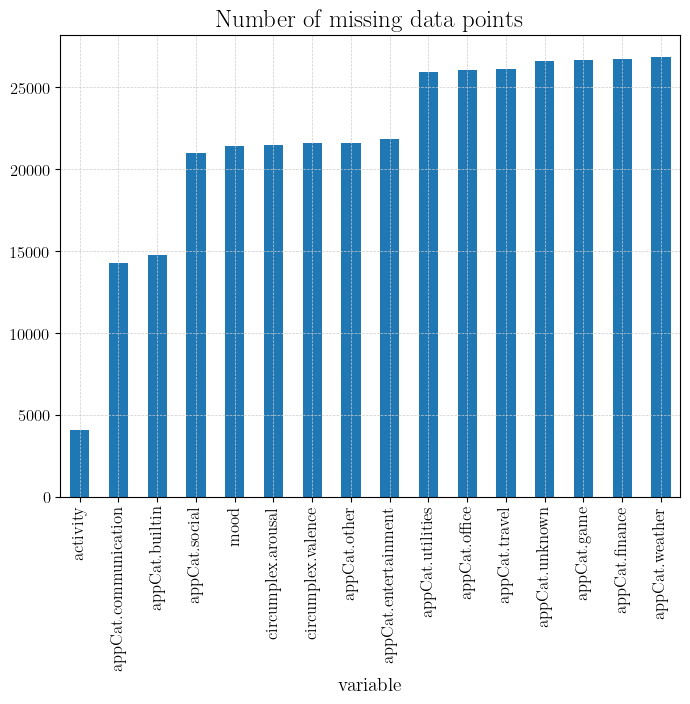

In [9]:
for column in data_pivot.columns:
    # window sliding fill
    if 0 < data_pivot[column].isnull().sum() < 500:
        data_pivot[column][data_pivot[column].isnull()] = data_pivot[column].rolling(4, min_periods=1).mean()
    

missing = data_pivot.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot(kind='bar', title='Number of missing data points')
plt.show()

# aggragating over days

In [10]:
day = data_pivot['time'].dt.floor('D')
data_pivot['day'] = day

day_data = data_pivot.groupby(['id', 'day']).mean()
day_data.reset_index(inplace=True)

Visualizing the missing days now

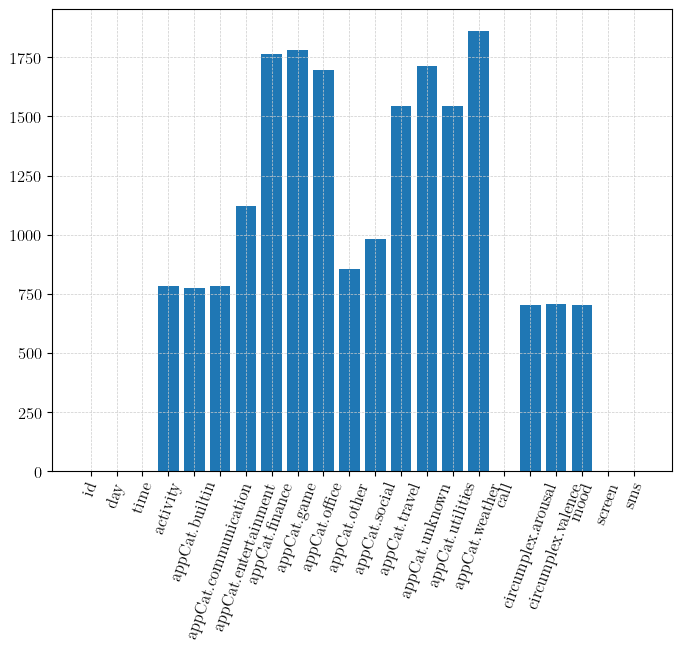

Total days measured: 1973, days with missing data 16


In [11]:
missing = day_data.isnull().sum()
plt.bar(missing.index, missing)
plt.xticks(np.arange(0, len(missing), 1), missing.index, rotation=70)
plt.show()
print(f'Total days measured: {len(day_data)}, days with missing data {len(missing[missing > 0])}')

## Analysis of missing data

<Axes: >

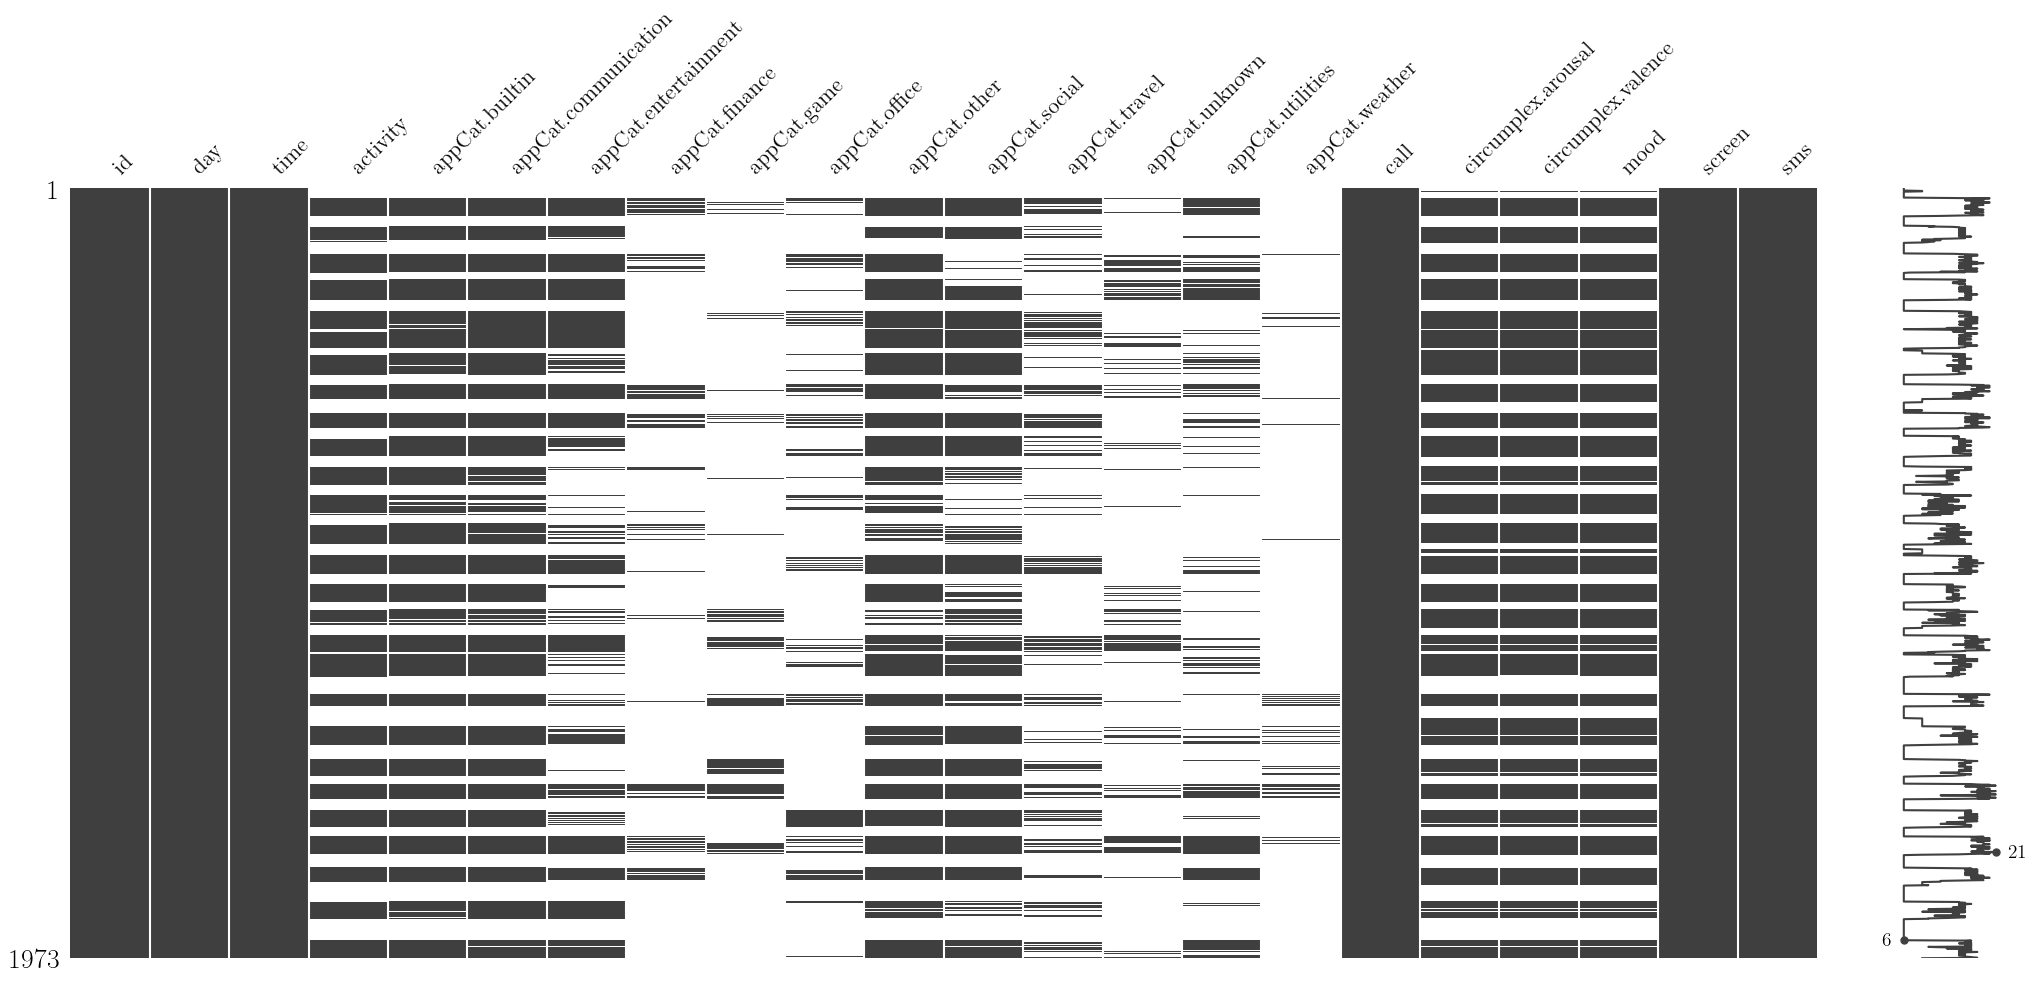

In [12]:
mo.matrix(day_data)

<Axes: xlabel='variable', ylabel='variable'>

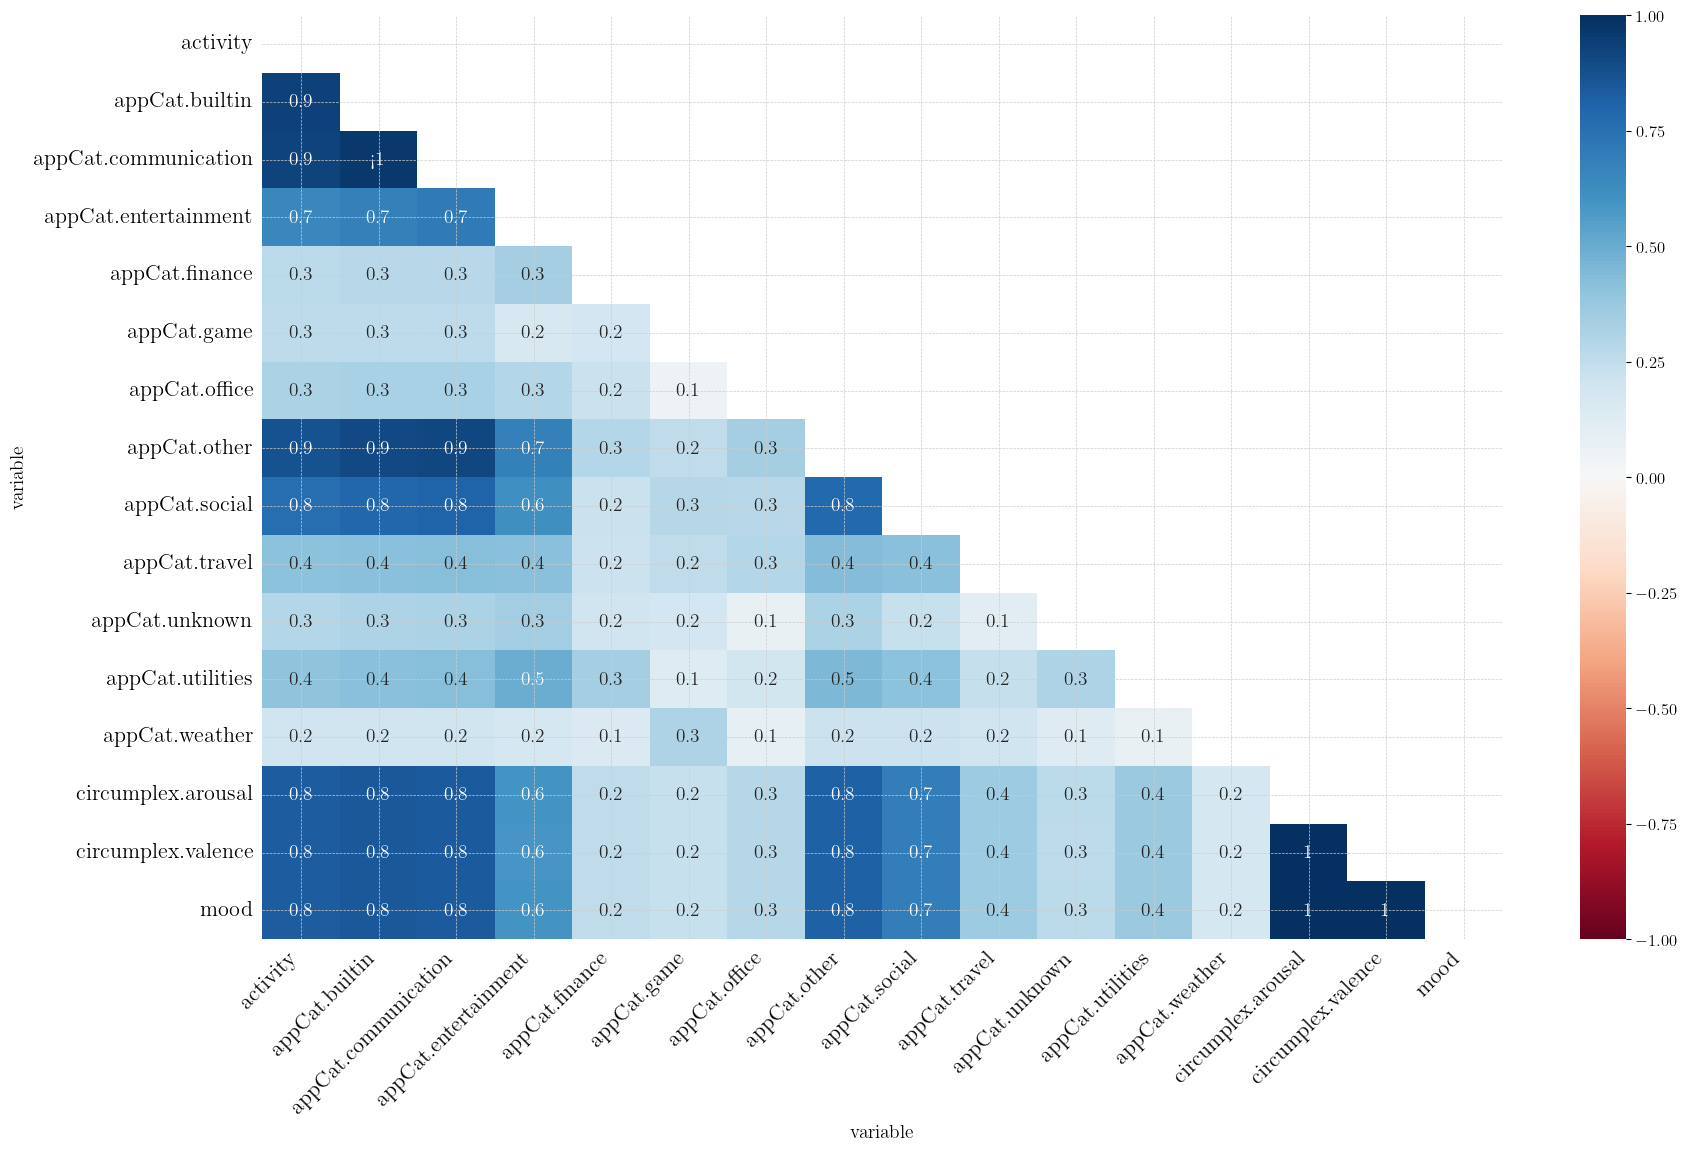

In [13]:
mo.heatmap(day_data)

<Axes: >

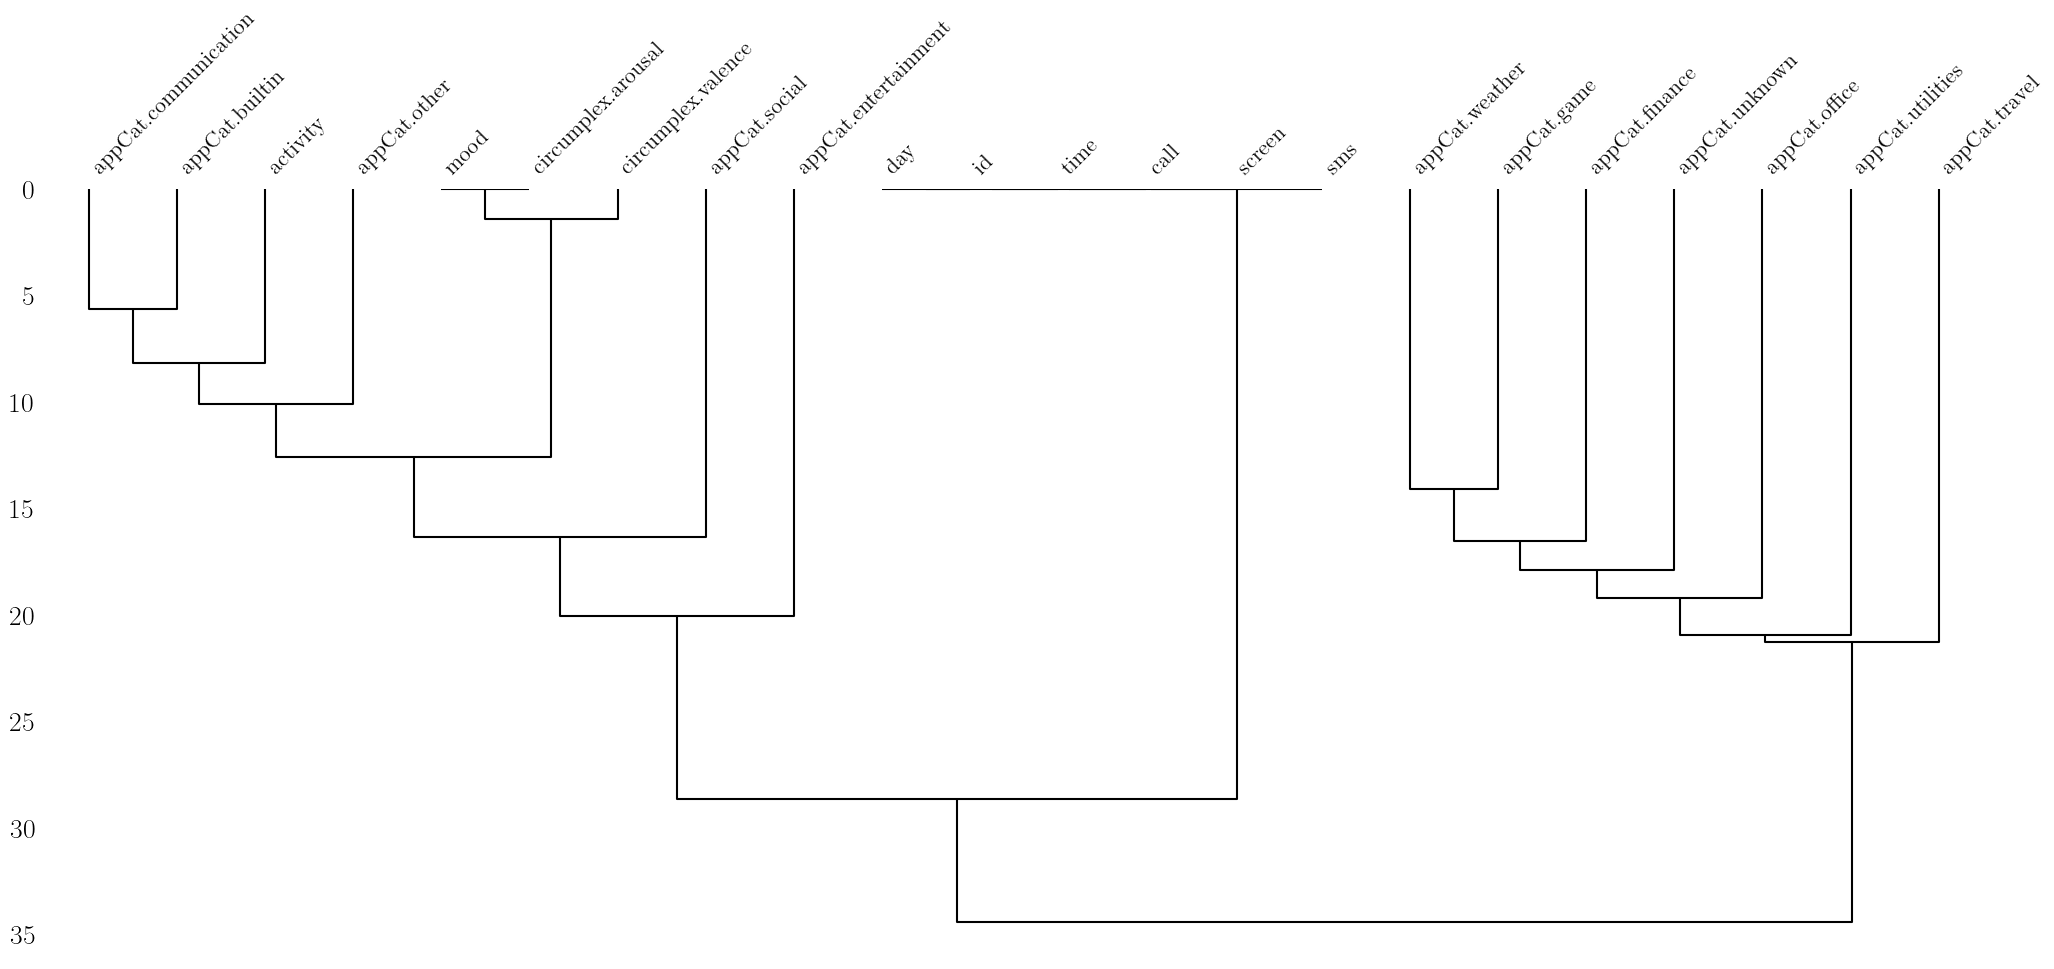

In [14]:
mo.dendrogram(day_data)

In [15]:
for column in day_data.columns:
    if 'appCat.' in column:
        day_data[column].fillna(0, inplace=True)

/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_24793/2795811557.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  day_data[column].fillna(0, inplace=True)


<Axes: >

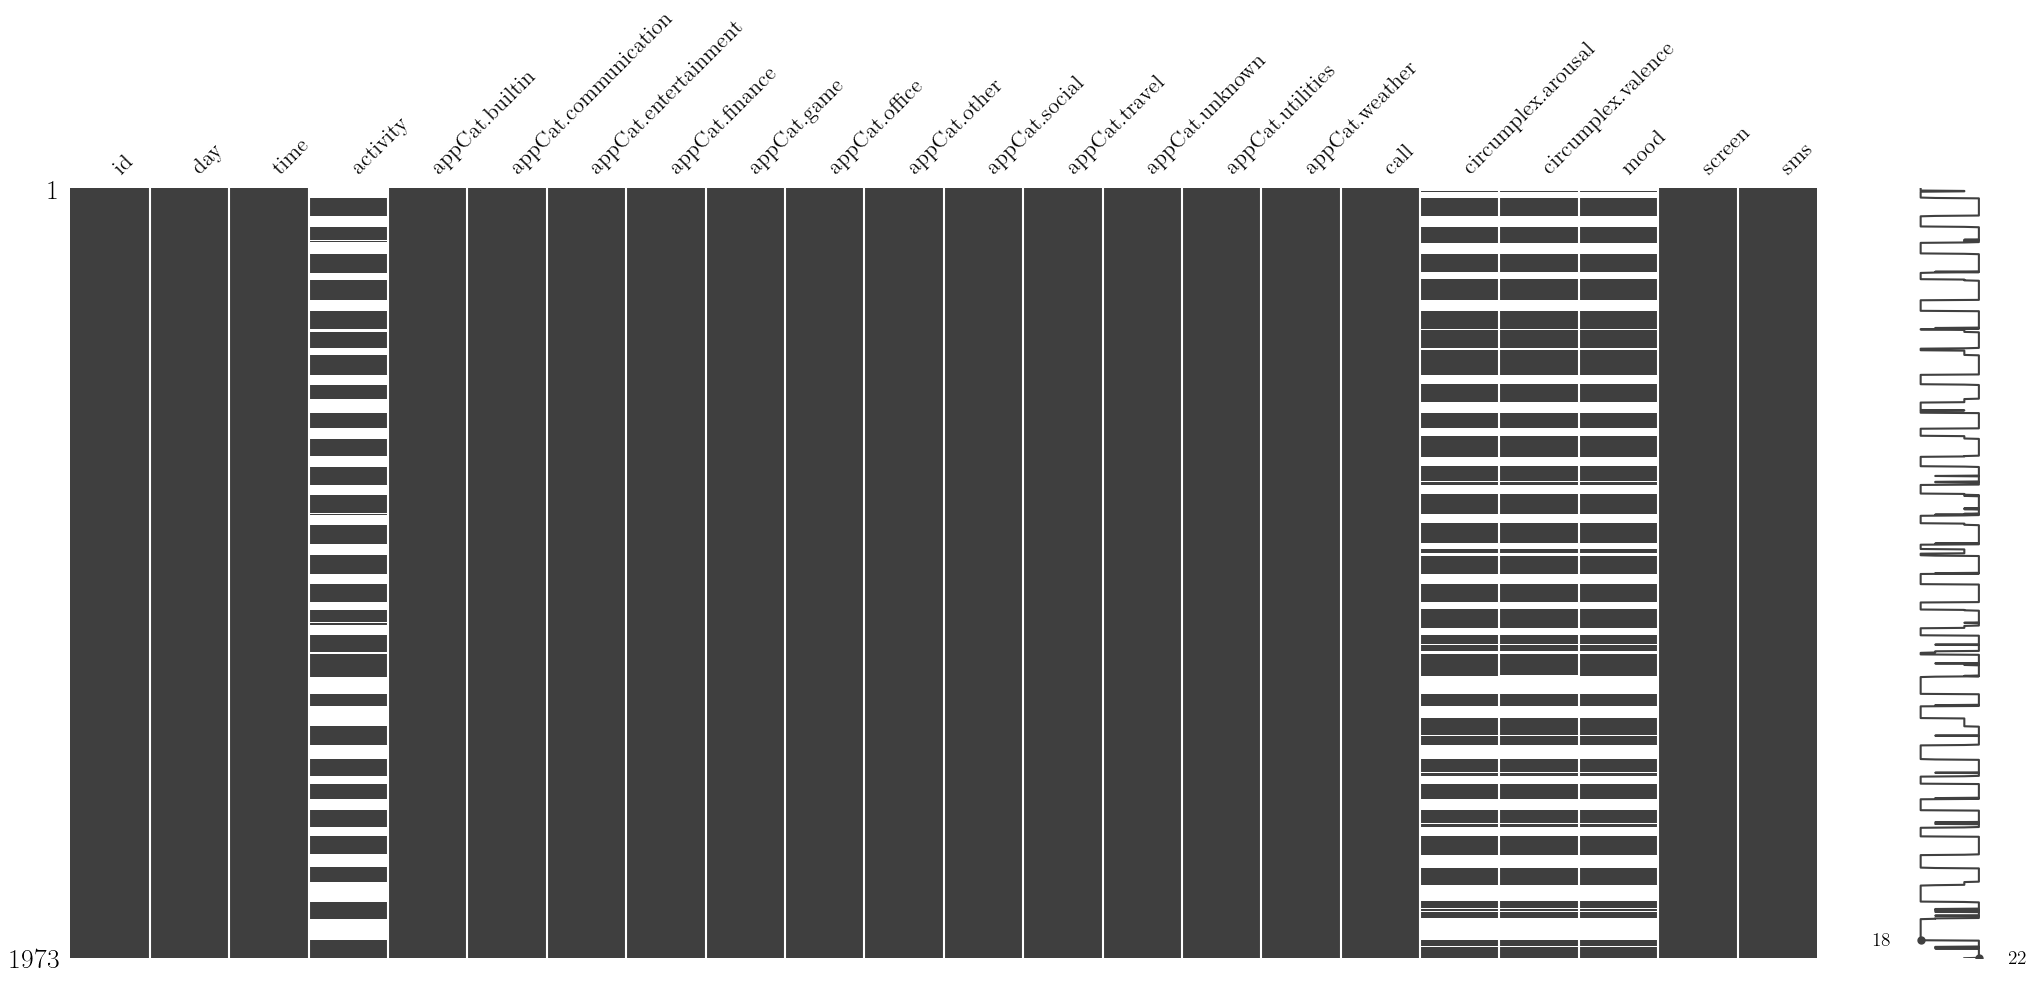

In [16]:
mo.matrix(day_data)

<Axes: xlabel='variable', ylabel='variable'>

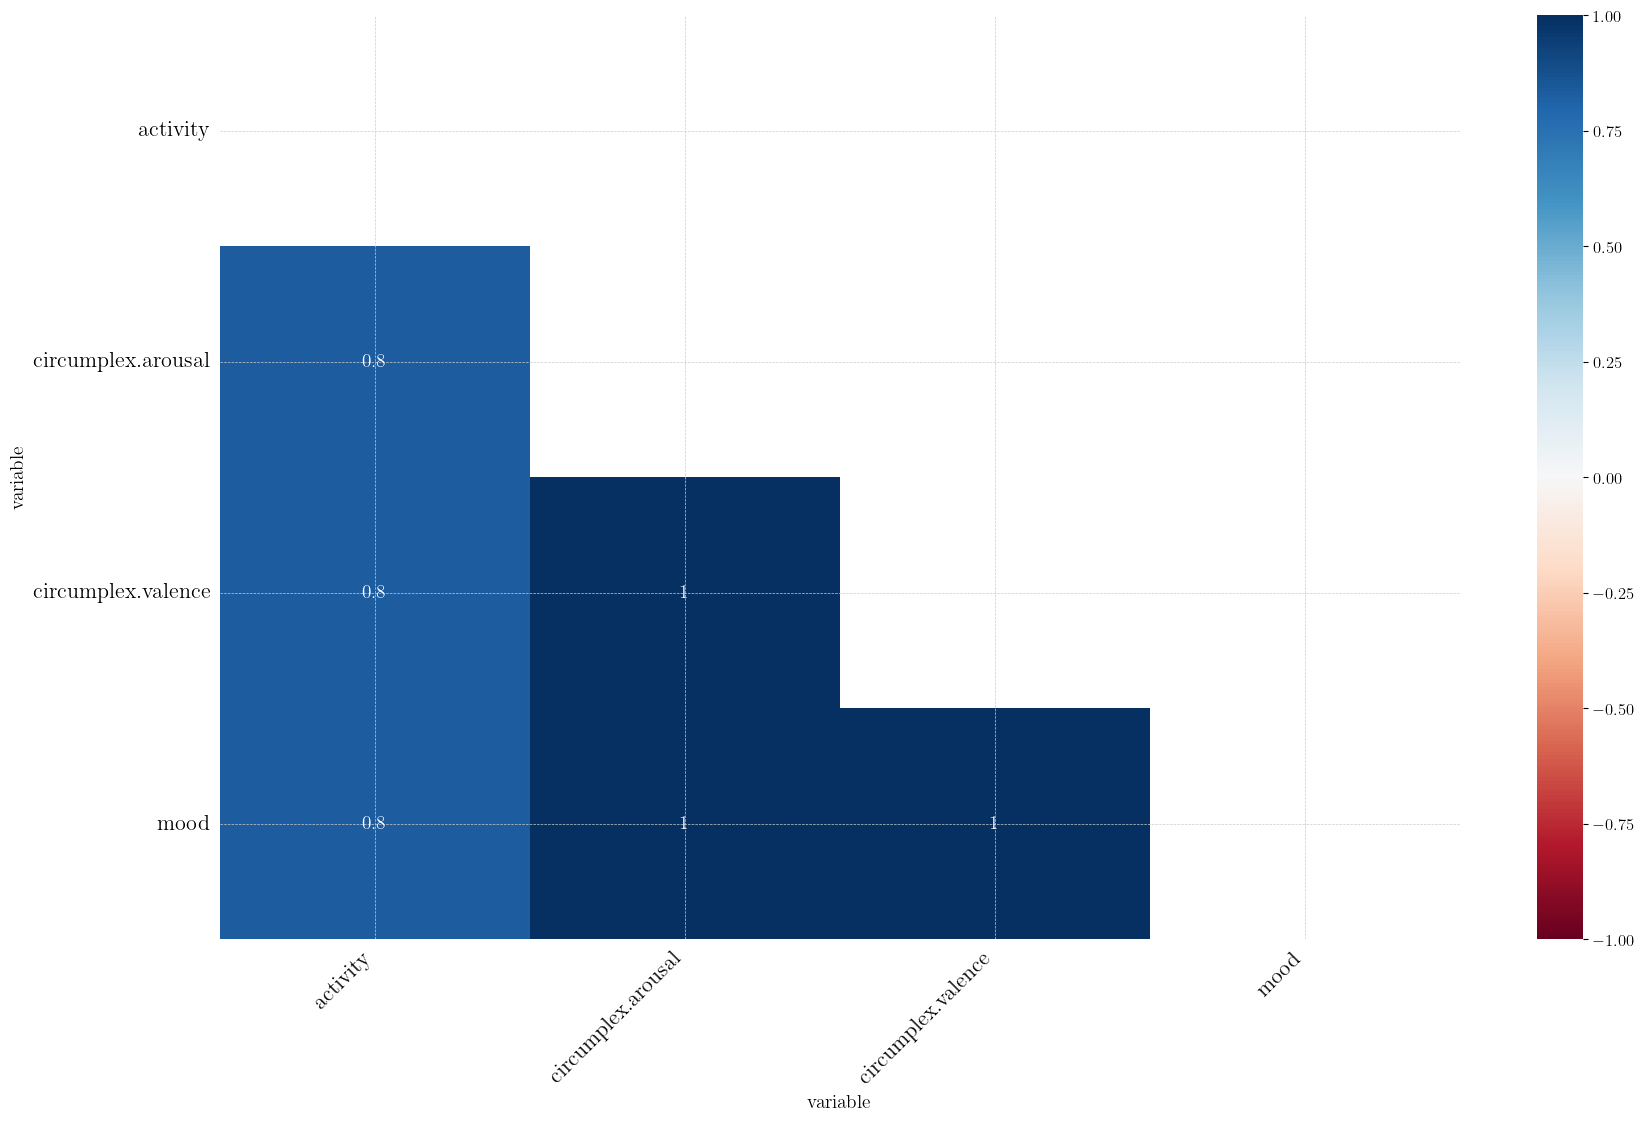

In [17]:
mo.heatmap(day_data)

<Axes: >

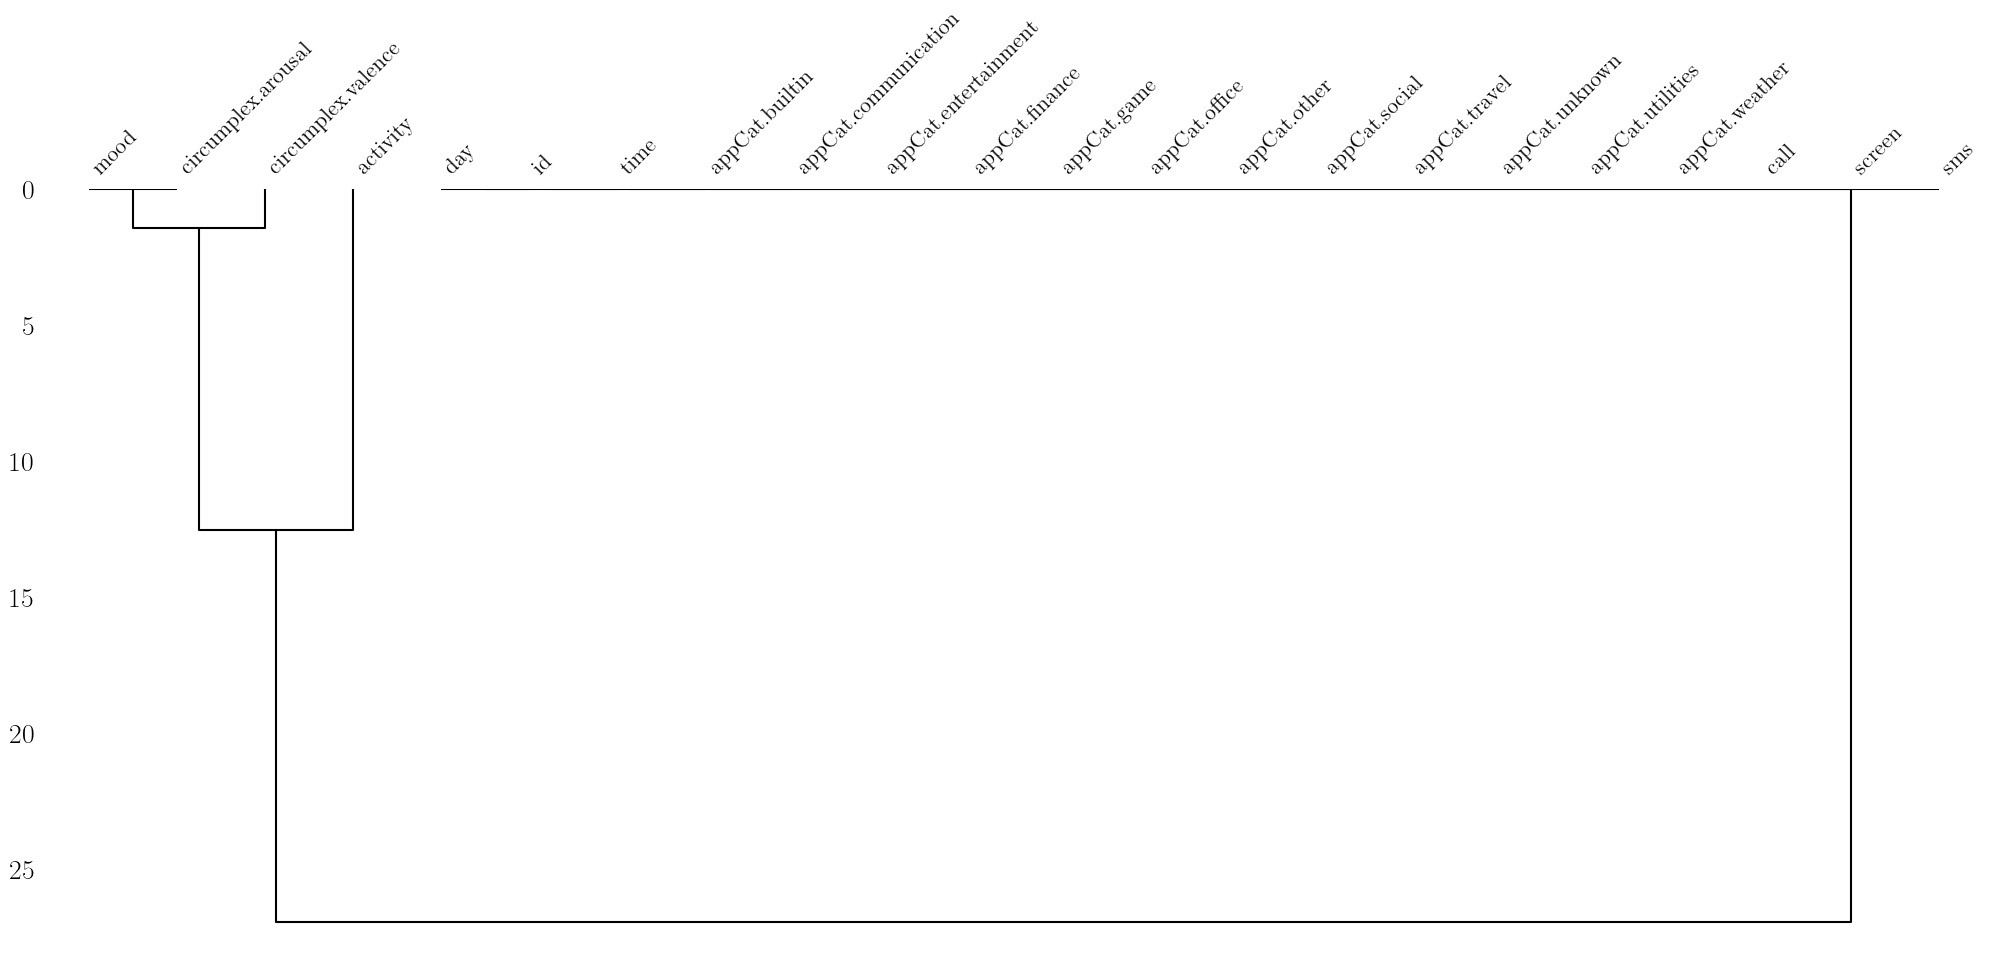

In [18]:
mo.dendrogram(day_data)

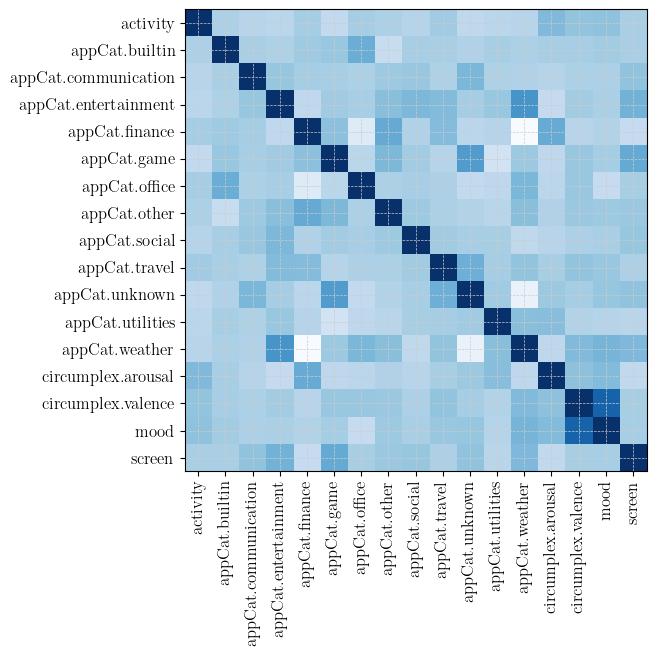

In [19]:
# get correlation matrix ignoring time and id

# numeric only
num_grouped = data_pivot.select_dtypes(include=[np.number])
# Drop call and sms variables
num_grouped = num_grouped.drop(columns=['call', 'sms'])
corr = num_grouped.corr()
plt.imshow(corr, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

## More Data Visualizations, i.e. stuff Sophie just added
It seems like something might be strange about the call and SMS data because they produce the exact same graph. 

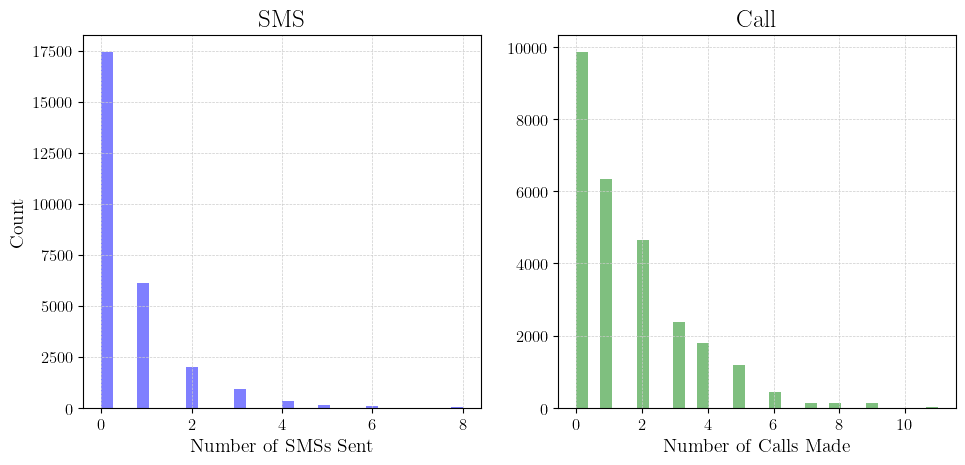

In [20]:
#Histograms for Call and SMS overall

sms_data = data_pivot["sms"]
call_data = data_pivot["call"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(sms_data, bins=30, color='blue', alpha=0.5)
axes[0].set_xlabel("Number of SMSs Sent")
axes[0].set_ylabel("Count")
axes[0].set_title('SMS')

axes[1].hist(call_data, bins=30, color='green', alpha=0.5)
axes[1].set_xlabel("Number of Calls Made")
axes[1].set_title('Call')

plt.tight_layout()
plt.show()

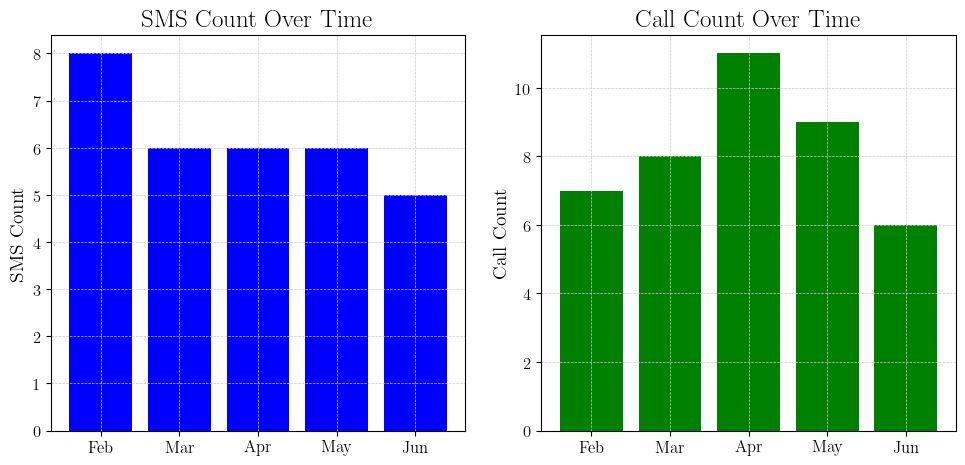

In [21]:
#Bar plots for call and SMS over time

days = data_pivot['day']
sms_counts = data_pivot['sms']
call_counts = data_pivot['call']
time_sorted = sorted(days)
sorted_sms_counts = [sms_counts[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
sorted_call_counts = [call_counts[index] for index in sorted(range(len(days)), key=lambda x: days[x])]
months = [date.strftime('%b') for date in time_sorted]

#SMS Data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].bar(months, sorted_sms_counts, color='blue', alpha=0.5)
axes[0].set_ylabel('SMS Count')
axes[0].set_title('SMS Count Over Time')

#Call Data
axes[1].bar(months, sorted_call_counts, color='green', alpha=0.5)
axes[1].set_ylabel('Call Count')
axes[1].set_title('Call Count Over Time')


plt.tight_layout()
plt.show()


## Outlier Identification

In [22]:
#Trying some methods for identifying outliers. First, with the most basic using interquartile range.

def identify_outliers_IQR(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

outliers_info = {}
variables = ['screen', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 
             'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 
             'appCat.utilities']

for variable in variables: 
    outliers = identify_outliers_IQR(data_pivot[variable])
    outliers_info[variable] = outliers

for variable in variables:
    outlier_list = []
    for i in range(len(outliers_info[variable])):
         if outliers_info[variable][i] == True:
            outlier_list.append(i)
    
    if outlier_list:
        print(f"Outliers in {variable} found at indices: {outlier_list}")

Outliers in screen found at indices: [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 838, 839, 840, 841, 842, 843, 844, 

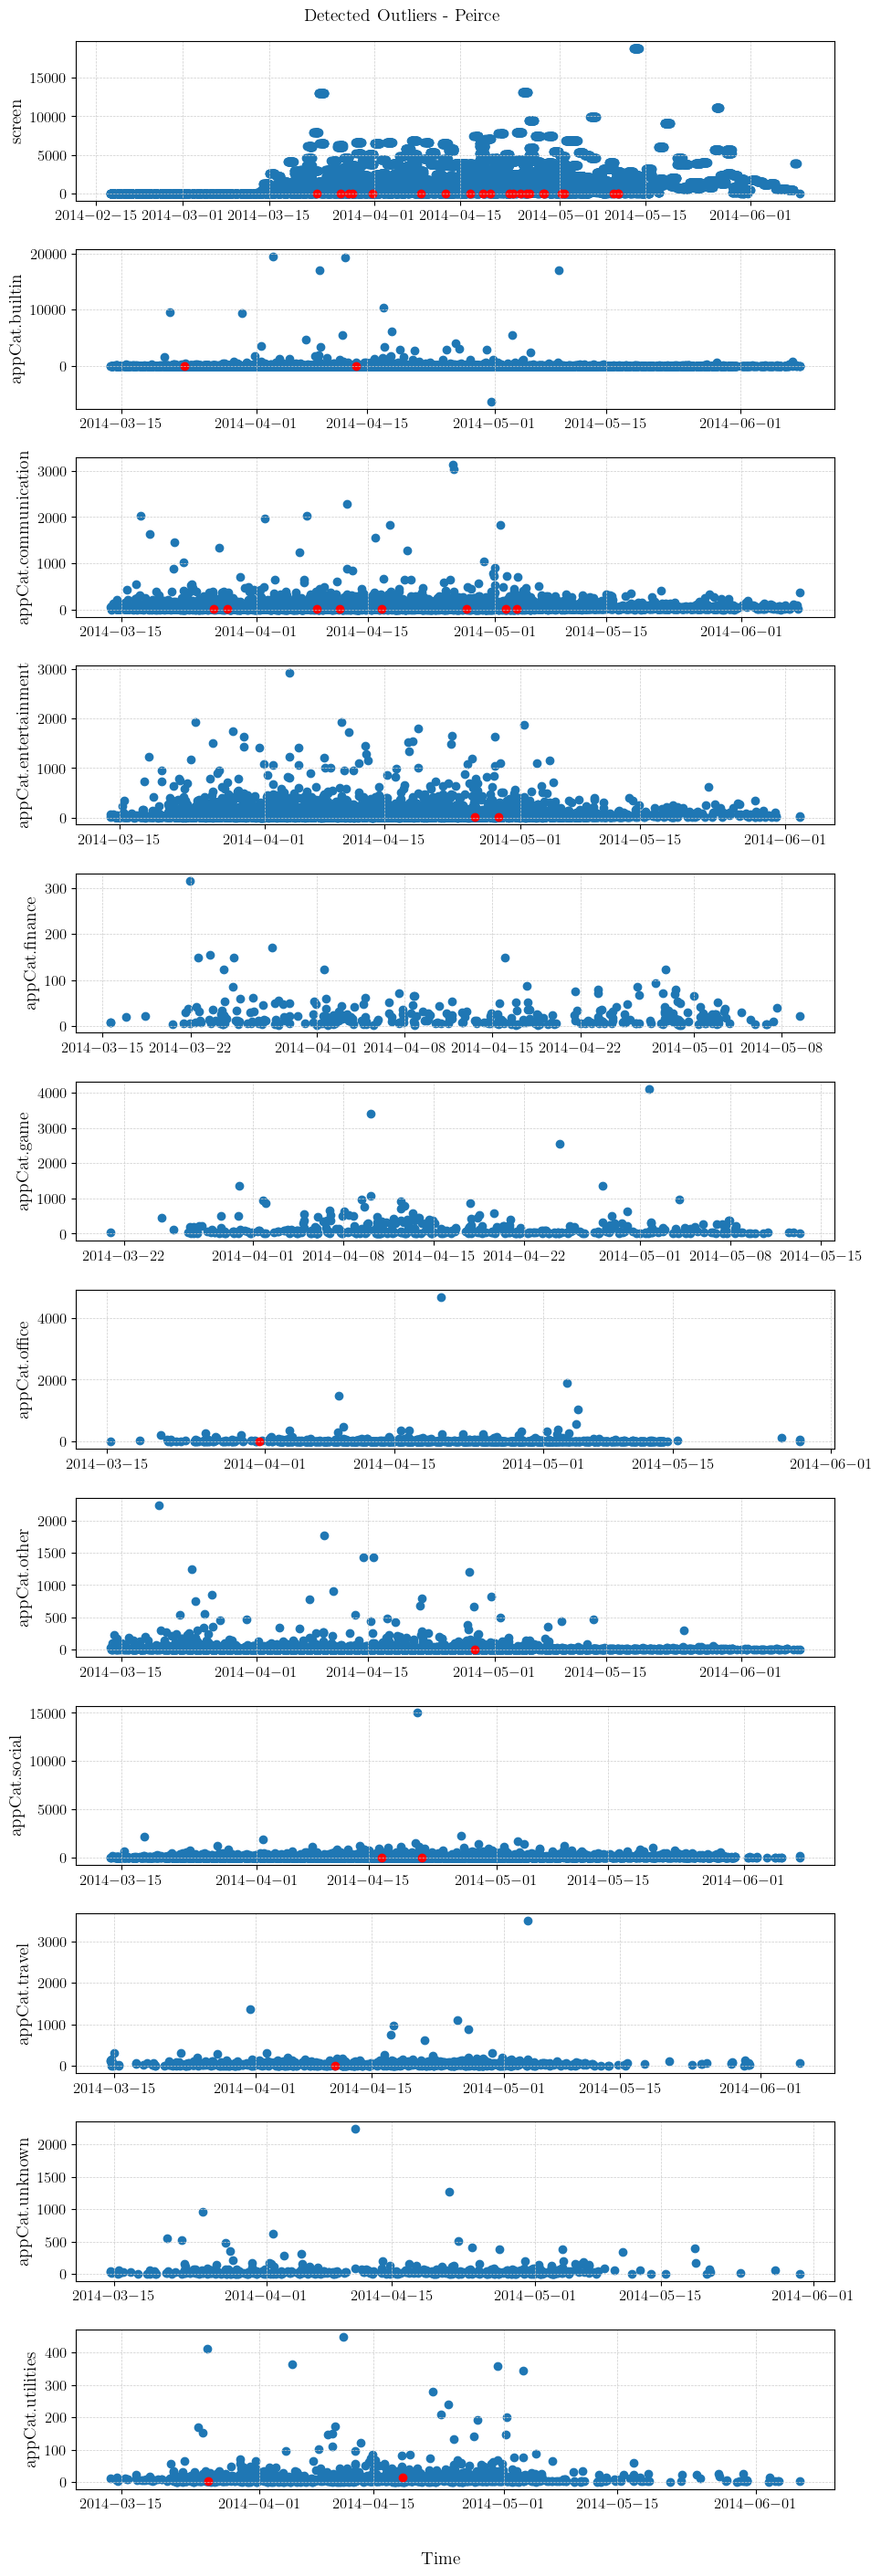

In [39]:
#Trying another method to confirm using Peirce's criterion. A bit easier than Cook's distance and more generalizable than Grubbs.

def identify_outliers_peirce(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    absolute_deviations = np.abs(data - mean)
    threshold = 3 * std_dev
    outliers = np.where(absolute_deviations > threshold)[0]
    return outliers

#Plotting the Outliers
data_pivot = data_pivot.sort_values(by='time')        
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(10, 30))
for i, variable in enumerate(variables):
    outliers = identify_outliers_peirce(data_pivot[variable])
    if len(outliers) > 0:
        axes[i].scatter(data_pivot['time'], data_pivot[variable], label=variable)
        axes[i].scatter(data_pivot['time'][outliers], data[outliers], color='red', label='Outliers')
    
    axes[i].set_ylabel(variable)

# Set common x-label and adjust layout
fig.text(0.5, 0.02, 'Time', ha='center', fontsize=14)
fig.text(0.35, 0.95, 'Detected Outliers - Peirce', va='center', rotation='horizontal', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [24]:
#Shapiro-Wilk Tests for normality to see if we can use Grubb's Test
normality_results = {}

for variable in variables:
    data = data_pivot[variable]
    stat, p_value = shapiro(data)
    if p_value > 0.05:
        normality_results[variable] = 'Normally distributed'
    else:
        normality_results[variable] = 'Not normally distributed'

for variable, result in normality_results.items():
    print(f"Result for {variable}: {result}")


Result for screen: Not normally distributed
Result for appCat.builtin: Normally distributed
Result for appCat.communication: Normally distributed
Result for appCat.entertainment: Normally distributed
Result for appCat.finance: Normally distributed
Result for appCat.game: Normally distributed
Result for appCat.office: Normally distributed
Result for appCat.other: Normally distributed
Result for appCat.social: Normally distributed
Result for appCat.travel: Normally distributed
Result for appCat.unknown: Normally distributed
Result for appCat.utilities: Normally distributed


/var/folders/k8/f4s3z1312zg_dxlmjk7hjk1c0000gn/T/ipykernel_24793/4164244619.py:6: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27028.
  stat, p_value = shapiro(data)


In [25]:
#Grubb's Test - currently will produce an error because of NaN

grubbs_results = {}
#for variable in variables:
#     outlier_index = grubbs.max_test_indices(data_pivot[variable], alpha=.05)
#     grubbs_results[variable] = outlier_index

# for variable, result in grubbs_results.items():
#     print(f"Result for {variable}: {result}")